# Welcome to `bruges`

This notebook accompanies [a blog post on agilegeoscience.com](http://www.agilegeoscience.com/blog/). 

If you are running this locally, you need to install [`bruges`](https://github.com/agile-geoscience/bruges) first:

    pip install bruges

This notebook also requires [`welly`](https://github.com/agile-geoscience/welly), which you can install like so:

    pip install welly
    
Check you're on version 0.3.2+ and then do 'the usual' imports.

In [1]:
import bruges
bruges.__version__

'0.3.3'

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

<hr />

## AVO calculations on individual layers

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |  
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [3]:
# Upper layer rock properties
vp1 = 3300.0
vs1 = 1500.0
rho1 = 2400.0

# Lower layer rock properties
vp2 = 3050.0
vs2 = 1400.0
rho2 = 2075.0

In [4]:
bruges.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0)

array(-0.11199578+0.j)

This is an `np.ndarray` of zero dimensions. You can use it just like a scalar value (or, in this case, a complex scalar).

When calling `akirichards`, it might be more convenient to use list unpacking. That way we can pass the arguments as two lists, or 'rocks':

In [5]:
rock1 = [vp1, vs1, rho1]
rock2 = [vp2, vs2, rho2]

In [6]:
bruges.reflection.akirichards(*rock1, *rock2, theta1=0)

array(-0.11199578+0.j)

We can also request the reflection coefficient at a particular angle, or a range of angles:

In [7]:
bruges.reflection.akirichards(*rock1, *rock2, theta1=30)

array(-0.0965207+0.j)

## Terms of Shuey's approximation

We can get the individual terms of Shuey's linear approximation:

In [8]:
rc_terms = bruges.reflection.shuey(*rock1, *rock2, theta1=30, terms=True)
rc_terms

Shuey(R0=array(-0.11199578), Rg=array(0.01968894), Rf=array(-0.00328084))

The second term is the product of gradient and $\sin^2 \theta$, but you can get at the gradient directly with an option:

In [9]:
intercept, gradient = bruges.reflection.shuey(*rock1, *rock2, return_gradient=True)
intercept, gradient

(-0.11199577706417983, 0.07875574410366709)

You can equally well pass in a list or array of angles,

In [10]:
theta_list = [0, 10, 20, 30]
rc_list = bruges.reflection.akirichards(*rock1, *rock2, theta1=theta_list)
rc_list

array([-0.11199578+0.j, -0.10982911+0.j, -0.10398651+0.j, -0.0965207 +0.j])

Create an array of angles from 0 to 70, incremented by 1,

In [11]:
theta_range = np.arange(0, 70)

In [12]:
rc_range = bruges.reflection.akirichards(*rock1, *rock2, theta1=theta_range)

Compare the two-term Aki-Richards approximation with the full Zoeprittz equation for a interface between two rocks:

In [13]:
rc_z = bruges.reflection.zoeppritz_rpp(*rock1, *rock2, theta1=theta_range)

Put all this data (just the real parts) on an AVO plot:

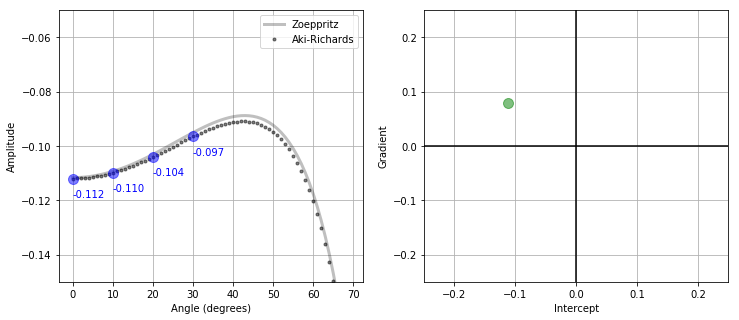

In [14]:
style = {'color': 'blue',
         'fontsize': 10,
         'ha':'left',
         'va':'top',}

fig = plt.figure(figsize=(12,5))

# AVO plot
ax1 = fig.add_subplot(121)
ax1.plot(theta_range, rc_z.real, 'k', lw=3, alpha=0.25, label='Zoeppritz')
ax1.plot(theta_range, rc_range.real, 'k.', lw=3, alpha=0.5, label='Aki-Richards')

# We'll also add the four angles...
ax1.plot(theta_list, rc_list.real, 'bo', ms=10, alpha=0.5)

# Putting some annotations on the plot.
for theta, rc in zip(theta_list, rc_list.real):
    ax1.text(theta, rc-0.004, '{:.3f}'.format(rc), **style)

ax1.legend()
ax1.set_ylim((-0.15, -0.05))
ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Amplitude')
ax1.grid()

# Intercept-Gradient crossplot.
ax2 = fig.add_subplot(122)
ax2.plot(intercept, gradient, 'go', ms=10, alpha = 0.5)

# Put spines for x and y axis.
ax2.axvline(0, color='k')
ax2.axhline(0, color='k')

# Set square axes limits.
mx = 0.25
ax2.set_xlim((-mx, mx))
ax2.set_ylim((-mx, mx))

# Label the axes and add gridlines.
ax2.set_xlabel('Intercept')
ax2.set_ylabel('Gradient')
ax2.grid()

plt.show()

<hr />

## Elastic modulus calculations

Say I want to compute the Lamé parameters &#955; and &#181;, from V<sub>P</sub>, V<sub>S</sub>, and Density. As long as my inputs are in SI units, I can insert these values directly:

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [15]:
# Upper layer only
bruges.rockphysics.lam(*rock1), bruges.rockphysics.mu(*rock1)

(15336000000.0, 5400000000.0)

Let's do this on real data. We'll use `welly` to load a well, inspect the curves, and compute using those.

In [16]:
import welly
welly.__version__

'0.3.4'

In [17]:
w = welly.Well.from_las('../data/R-39.las')

In [18]:
p = welly.Project([w])
from IPython.display import HTML
HTML(p.curve_table_html())

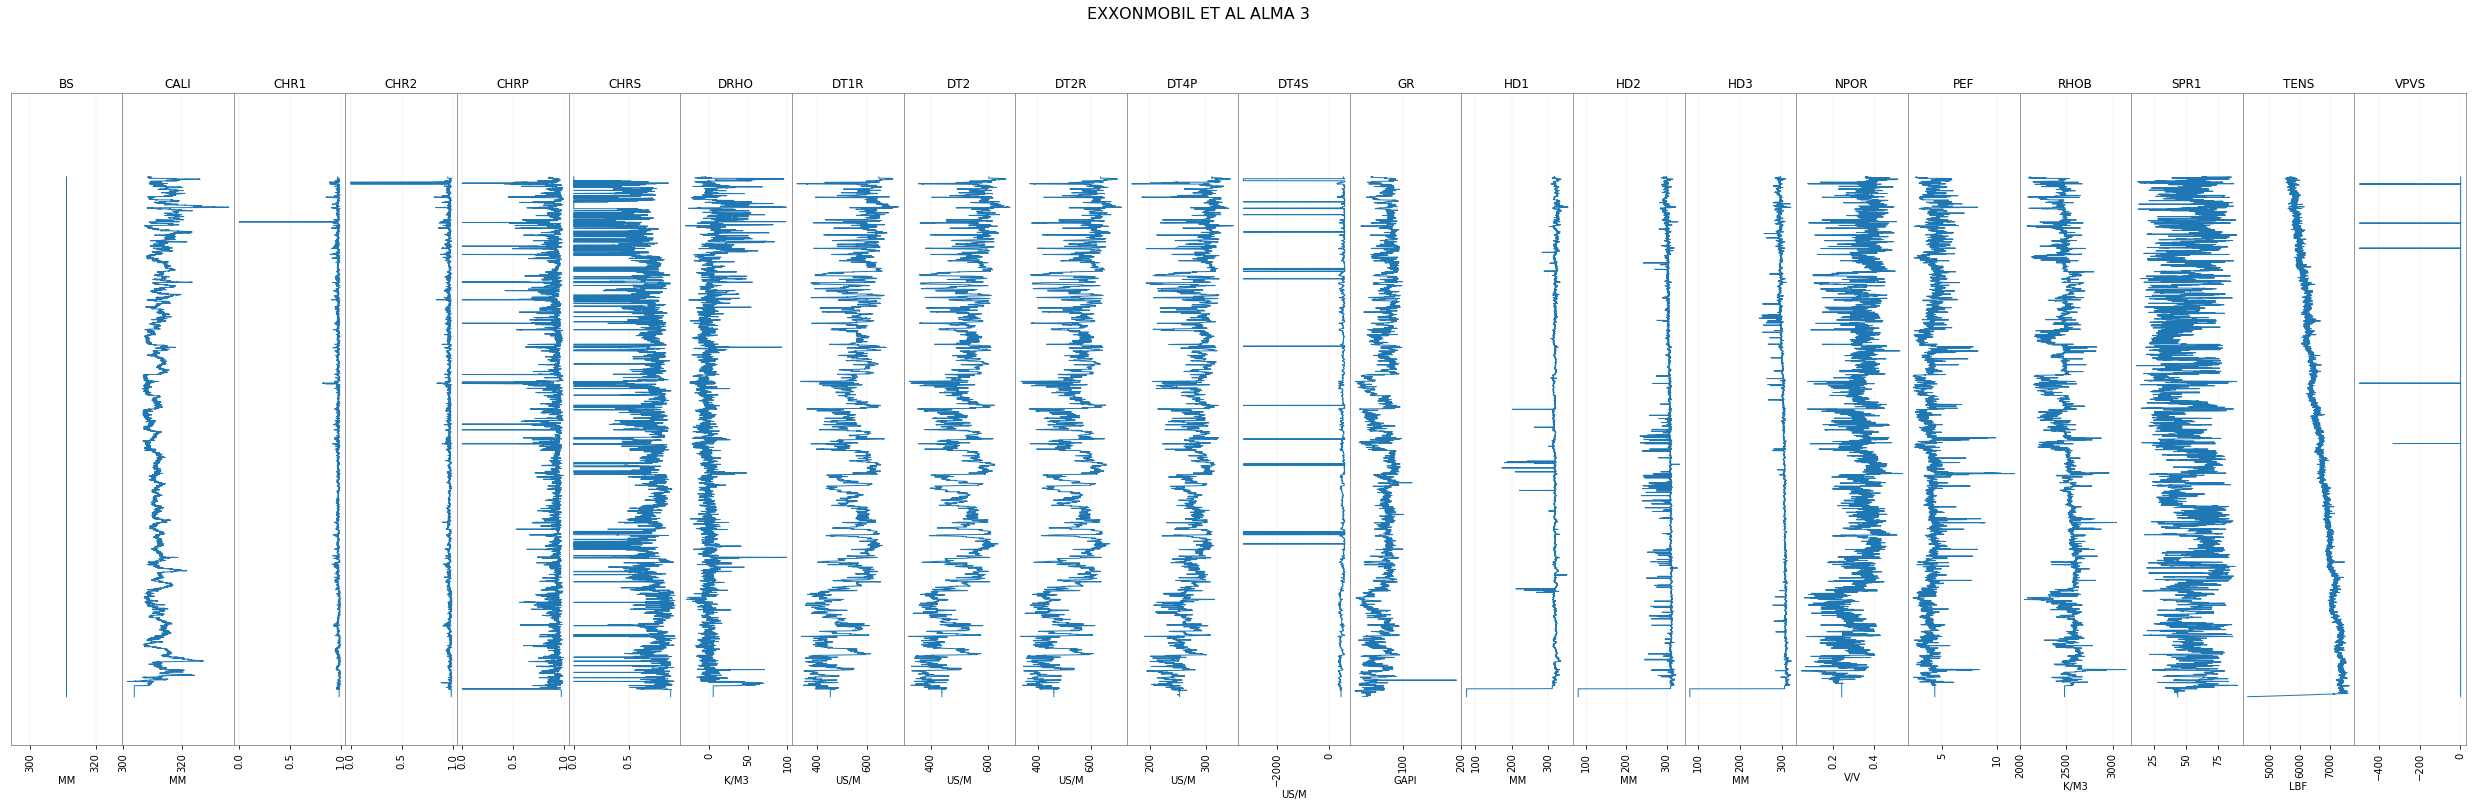

In [19]:
w.plot(extents=(2000,3500))

In [20]:
w.data['DT4P']

Curve([311.0284, 311.0284, 311.0284, ..., 252.4951, 252.4951, 252.4951])

Turn things into Python variables for convenience.

In [21]:
dtp = w.data['DT4P']
dts = w.data['DT4S']
rhob = w.data['RHOB']

Convert velocities and get a depth basis:

In [22]:
z = dtp.basis

In [23]:
vp =  1e6 / dtp
vp.units = 'm/s'
vs =  1e6 / dts
vs.units = 'm/s'

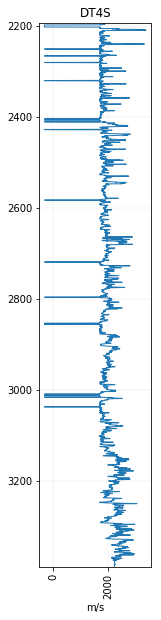

In [24]:
vs.plot()

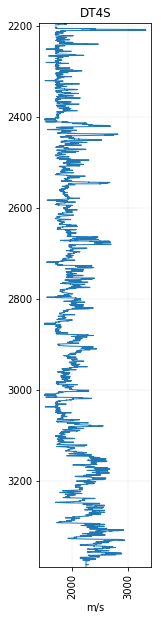

In [25]:
vs = vs.despike(24, z=0.5)
vs[vs < 0] = np.nan
vs.plot()

Now the rock properties...

In [26]:
lm = bruges.rockphysics.lam(vp, vs, rhob)
mu = bruges.rockphysics.mu(vp, vs, rhob)

Create a crossplot:

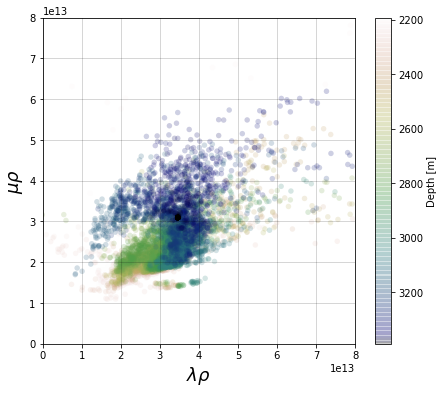

In [27]:
plt.figure(figsize=(7,6))

plt.scatter(lm*rhob, mu*rhob,
            s=30,  # marker size
            c=z, cmap="gist_earth_r",
            edgecolor='none',
            alpha=0.2)

# Give the plot a colorbar.
cb = plt.colorbar()
cb.ax.invert_yaxis()
cb.set_label("Depth [m]")

# Give the plot some annotation.
plt.xlabel(r'$\lambda \rho$', size=18)
plt.ylabel(r'$\mu \rho$', size=18)
plt.grid(color='k', alpha=0.2)
plt.xlim(0, 8e13)
plt.ylim(0, 8e13)
plt.show()

<hr />

## Backus averaging

In [28]:
lb = 60        # Backus averaging length in metres.
dz = vp.step   # Sample interval of the log in metres.

In [29]:
vp0, vs0, rhob_filt = bruges.rockphysics.backus(vp, vs, rhob, lb, dz)

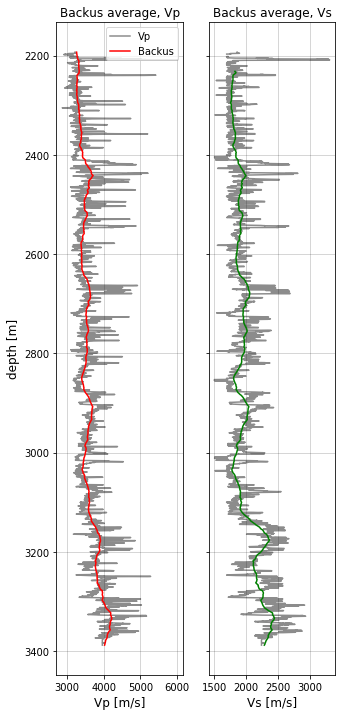

In [30]:
fig, axs = plt.subplots(figsize=(5,12), ncols=2)

ax = axs[0]
ax.plot(vp, z, 'k', alpha=0.45, label='Vp')
ax.plot(vp0, z, 'r', label='Backus')
ax.set_title('Backus average, Vp')
ax.set_ylabel(r'depth [m]', size=12)
ax.invert_yaxis()
ax.set_xlabel(r'Vp [m/s]', size=12)
ax.grid(color='k', alpha=0.2)
ax.legend()

ax = axs[1]
ax.plot(vs, z, 'k', alpha=0.45, label='Vp')
ax.plot(vs0, z, 'g', label='Backus')
ax.set_title('Backus average, Vs')
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_xlabel(r'Vs [m/s]', size=12)
ax.grid(color='k', alpha=0.2)

plt.show()

## Offset synthetic

The logs don't start at 0, so let's make a replacement layer, and give it a velocity ramp up to the start of the Vp log. 

In [31]:
repl = int(vp.start/vp.step)
velocity = np.pad(vp0, (repl, 0), mode='linear_ramp', end_values=2000)

Now we pad the logs up to a depth of 0 m.

In [32]:
vp0 = np.pad(vp0, (repl, 0), mode='edge', )
vs0 = np.pad(vs0, (repl, 0), mode='edge')
rhob_filt = np.pad(rhob_filt, (repl, 0), mode='edge')
z = np.pad(z, (repl, 0), mode='edge')

Now we time-convert the logs we need:

In [33]:
vpt, t = bruges.transform.depth_to_time(vp0, velocity, dt=0.001, dz=vp.step, return_t=True)
vst = bruges.transform.depth_to_time(vs0, velocity, dt=0.001, dz=vp.step)
rhot = bruges.transform.depth_to_time(rhob_filt, velocity, dt=0.001, dz=vp.step)

In [34]:
t

array([0.000e+00, 1.000e-03, 2.000e-03, ..., 2.284e+00, 2.285e+00,
       2.286e+00])

Make the reflection coefficient series:

In [35]:
rc = bruges.reflection.reflectivity(vpt, vst, rhot, theta=np.arange(60), method='zoeppritz_rpp')

Because the RC series is 1 value shorter than the logs, we have to lose a value from the time basis:

In [36]:
t = t[1:]

And a wavelet:

In [37]:
wavelet = bruges.filters.ricker(duration=0.128, dt=0.001, f=45)

Then perform convolution to make the synthetic response:

In [38]:
syn = np.apply_along_axis(lambda tr: np.convolve(tr, wavelet, mode='same'), arr=rc, axis=-1)

And plot the result:

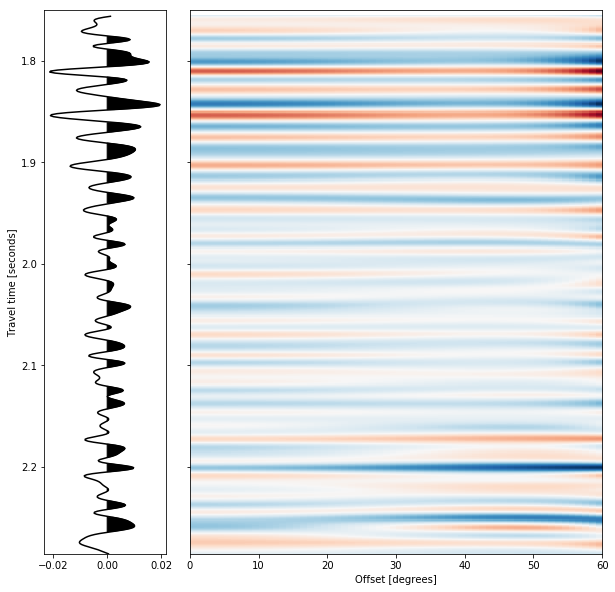

In [39]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(1, 4)
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(gs[0])
ax.plot(syn.real[0], t, 'k')
ax.fill_betweenx(t, 0, syn.real[0], where=syn.real[0]>0, color='k')
ax.set_ylim(np.amax(t), 1.75)
ax.set_ylabel('Travel time [seconds]')

ax = plt.subplot(gs[1:])
ax.imshow(syn.real.T, cmap='RdBu', aspect='auto', extent=[0, 60, np.amax(t), 0])
ax.set_ylim(np.amax(t), 1.75)
ax.set_yticklabels([])
ax.set_xlabel('Offset [degrees]')

plt.show()

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:right;" width="40px" /><p style="color:gray; float:right;">© 2018 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>